In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from keras.layers import Activation, Dropout, Conv2D, Dense
from keras.layers import MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential, load_model
from keras.layers import Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import cv2

In [2]:
df = pd.read_csv("fer2013/fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df.shape

(35887, 3)

<AxesSubplot:xlabel='emotion', ylabel='count'>

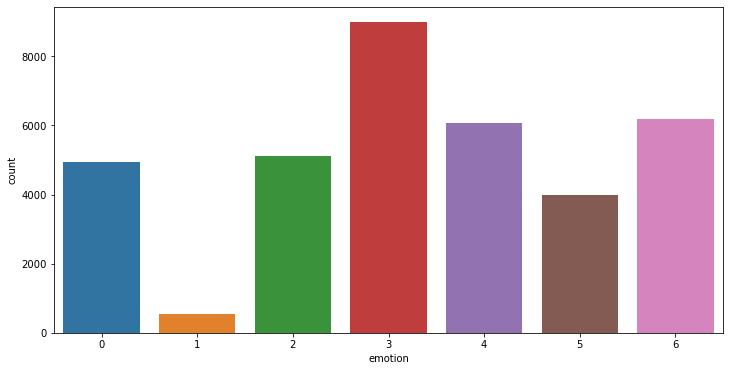

In [4]:
plt.figure(figsize=(12,6))
sns.countplot(x='emotion', data=df)

In [5]:
emotion_label = ["Neutral", "Disgusted", "Fearful", "Happy", "Sad", "Surprised", "Neutral"]

In [7]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

<AxesSubplot:xlabel='Usage', ylabel='count'>

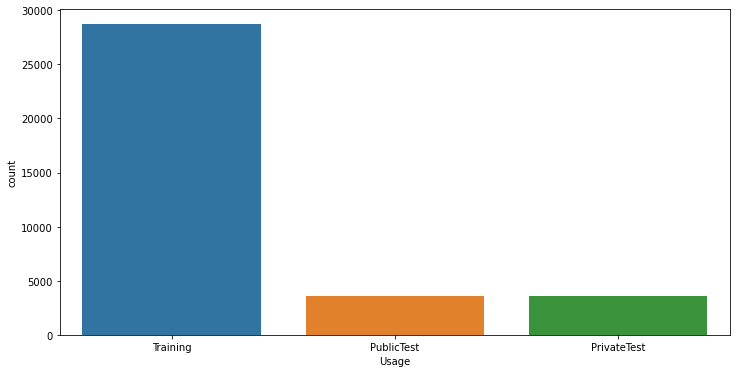

In [8]:
plt.figure(figsize=(12,6))
sns.countplot(x='Usage', data=df)

In [9]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [10]:
image_size=(48,48)
pixels = df['pixels'].tolist() # Converting the relevant column element into a list for each row
width, height = 48, 48
faces = []

for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')] # Splitting the string by space character as a list
    face = np.asarray(face).reshape(width, height) #converting the list to numpy array in size of 48*48
    face = cv2.resize(face.astype('uint8'),image_size) #resize the image to have 48 cols (width) and 48 rows (height)
    faces.append(face.astype('float32')) #makes the list of each images of 48*48 and their pixels in numpyarray form
    
faces = np.asarray(faces) #converting the list into numpy array
faces = np.expand_dims(faces, -1) #Expand the shape of an array -1=last dimension => means color space
emotions = pd.get_dummies(df['emotion']).to_numpy() #doing the one hot encoding type on emotions


In [11]:
print(faces.shape)
print(type(faces))
print(emotions[0])

(35887, 48, 48, 1)
<class 'numpy.ndarray'>
[1 0 0 0 0 0 0]


In [12]:
# Traning data
train_x = faces[:28709]
train_y = emotions[:28709]

# Validation data
val_x = faces[28709:]
val_y = emotions[28709:]

train_data = (train_x, train_y)
val_data = (val_x, val_y)

In [13]:
print('Training Pixels',train_x.shape)  # ==> 4 dims -  no of images , width , height , color
print('Training labels',train_y.shape)

print('Validation Pixels',val_x.shape)
print('Validation labels',val_y.shape)

Training Pixels (28709, 48, 48, 1)
Training labels (28709, 7)
Validation Pixels (7178, 48, 48, 1)
Validation labels (7178, 7)


In [14]:
batch_size = 64 

In [16]:
train_generator = ImageDataGenerator(rescale=1./255,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [17]:
train_set = train_generator.flow(train_x, train_y, batch_size)

In [18]:
val_generator = ImageDataGenerator(rescale=1./255)

In [19]:
val_set = val_generator.flow(val_x, val_y, batch_size)

## Train Model

In [20]:
model = Sequential()
# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolution layer
model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolution layer
model.add(Conv2D(256,(3,3), padding='same', activation='relu'))
model.add(Conv2D(256,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 5th Convolution layer
# model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
# model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening or GlobalAveragePooling2D
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

# Fully connected layer 1st layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(len(emotion_label), activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
checkpoint = ModelCheckpoint('model/fer_bestmodel.hdf5', save_best_only=True, monitor="val_accuracy", mode='max', save_weights_only=False)  

In [24]:
hist= model.fit(train_set,
        epochs = 50,
        validation_data = val_set,
        callbacks=[checkpoint])

Epoch 1/50
449/449 [==============================] - 17s 33ms/step - loss: 2.0432 - accuracy: 0.2235 - val_loss: 1.9152 - val_accuracy: 0.1780
Epoch 2/50
449/449 [==============================] - 14s 32ms/step - loss: 1.6057 - accuracy: 0.3873 - val_loss: 1.5270 - val_accuracy: 0.4030
Epoch 3/50
449/449 [==============================] - 14s 31ms/step - loss: 1.3976 - accuracy: 0.4727 - val_loss: 1.4246 - val_accuracy: 0.4539
Epoch 4/50
449/449 [==============================] - 14s 32ms/step - loss: 1.2802 - accuracy: 0.5159 - val_loss: 1.4163 - val_accuracy: 0.4967
Epoch 5/50
449/449 [==============================] - 14s 31ms/step - loss: 1.1880 - accuracy: 0.5504 - val_loss: 1.2329 - val_accuracy: 0.5369
Epoch 6/50
449/449 [==============================] - 14s 31ms/step - loss: 1.1369 - accuracy: 0.5728 - val_loss: 1.1733 - val_accuracy: 0.5451
Epoch 7/50
449/449 [==============================] - 14s 31ms/step - loss: 1.1223 - accuracy: 0.5761 - val_loss: 1.2664 - val_accuracy:

In [25]:
# Evaluate the model from the last epoch
score = model.evaluate(val_set, verbose=0 )
print( "Test results (model from the last epoch):", [ (model.metrics_names[i], score[i]) for i in range(len(score)) ] )

# Load and evaluate the model from the best epoch
best_model = load_model('model/fer_bestmodel.hdf5', compile=True )
score = best_model.evaluate(val_set, verbose=0 )
print( "Test results (model from the best epoch):", [ (best_model.metrics_names[i], score[i]) for i in range(len(score)) ] )

Test results (model from the last epoch): [('loss', 1.2502785921096802), ('accuracy', 0.6656450033187866)]
Test results (model from the best epoch): [('loss', 1.1657873392105103), ('accuracy', 0.6731680035591125)]


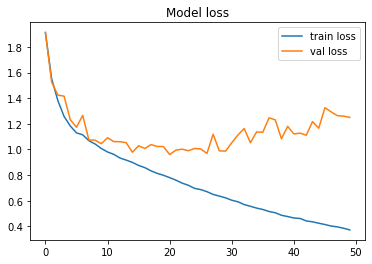

In [26]:
# loss
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.legend()
plt.show()

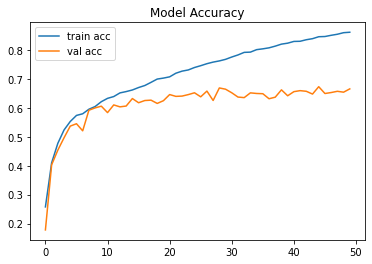

In [27]:
# accuracies
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.legend()
plt.show()